In [74]:
import pandas as pd
import networkx as nx
import numpy as np

import seaborn as sns; sns.set(style='white')

import matplotlib.pyplot as plt

import string

In [75]:
colors = ["#34495e", "#cd853f"]

# Journals

First, let us make some ranking measures on the journals of our database depending on the decile they are using the citation network.

In [76]:
cite = pd.read_csv("../data/processed/cites.csv")

cite = cite[(cite.t_year >= 1990) & (cite.t_year < 2020)]

In [77]:
jnls = cite.groupby('t_journal').size().rename("cites").reset_index()

jnls = pd.merge(jnls,
                cite.groupby('s_journal').size().rename("papers"),
                left_on="t_journal",
                right_index=True,
                how="left")

Let us create a new variable $i$ defined as the ratio between "cites" and "papers".

In [78]:
jnls['i'] = jnls['cites'] / jnls['papers']

Another variable $j$ that represents the decile in which the researcher is.

In [79]:
jnls['j'] = pd.qcut(jnls.cites, q=10, labels=list(reversed(string.ascii_uppercase))[-10:])

## Research groups

In [80]:
people = pd.read_csv("../data/processed/network_people.csv")

Not all people are in the network as some people only have single-authored papers.

In [81]:
all_people = pd.read_csv("../data/processed/people.csv")

## Add place of work

In [82]:
places = pd.read_csv("../data/processed/institution.csv")

places = places[['Handle', 'Primary-Name', 'alpha-3', 'region', 'sub-region']].set_index("Handle")

Let us add the place of work to the people.

In [83]:
people = pd.merge(people,
                  places,
                  left_on="Workplace-Institution",
                  right_index=True,
                  how="left")

all_people = pd.merge(all_people,
                  places,
                  left_on="Workplace-Institution",
                  right_index=True,
                  how="left")

## Add number of papers

In order to define two groups of researchers, those most succesful and the rest we are going to take their number of papers.

In [84]:
source = cite.groupby('source').size().rename('papers')

In [85]:
people = pd.merge(people,
                  source,
                  how="left",
                  left_on="Short-Id",
                  right_index=True)

In [86]:
# Take the sub-region per gender and group
freq = (people.groupby(['gender', 'group'])["sub-region"]
    .value_counts(normalize=True)
    .rename('frequency')
    .reset_index())

In [87]:
# Get the number of citations and papers per gender, group and sub-region
region = (people.groupby(['gender', 'group', 'sub-region'])
          .agg({'cites': [('cites', 'sum')], 'papers': [('papers', 'sum')]})
          .droplevel(axis=1, level=0)
          .reset_index())
# Add the number of people per sub-region
region = pd.merge(region, freq, how='left')
# Tidy the data
region = (region
          .melt(id_vars=['gender', 'group', 'sub-region'],
                value_vars=['cites', 'frequency', 'papers'],
                value_name='value'))

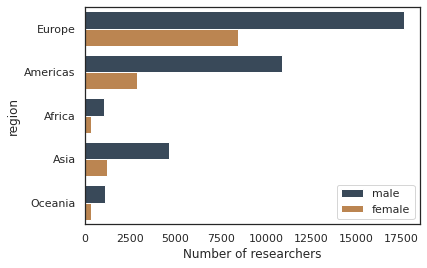

In [88]:
# Plot of all researchers (including single-author)
with sns.color_palette(colors):
    g = sns.countplot(y="region", hue="gender", data=all_people)
    g.set_xlabel("Number of researchers")
    plt.legend(fancybox=True);
plt.savefig("../figures/overall_gender_ratio.png", dpi=300)

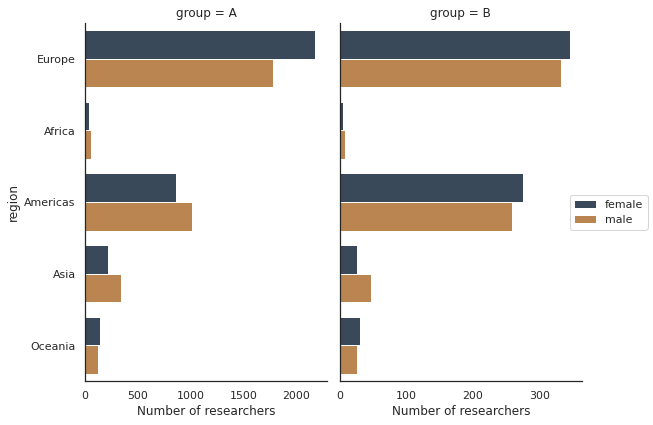

In [89]:
# Plot the people in the citation network
with sns.color_palette(colors):
    g = sns.catplot(col="group", y="region",
            hue="gender", data=people,
            kind="count", sharex="col", legend=False)
    g.axes[0,0].set_xlabel('Number of researchers');
    g.axes[0,1].set_xlabel('Number of researchers');
g.add_legend(frameon=True, fancybox=True)
g.fig.set_size_inches(9, 6)
g.savefig("../figures/gender_region.png", dpi=300)

## Let us take a look at the citation network

We are interested in knowing if researchers cite more their gender in:

1) The overall network

2) The successful researchers network

3) The average researchers network

4) Networks A and B together

In [90]:
# Overall network
G_i = nx.from_pandas_edgelist(cite, source="source",
                            target="target",
                            create_using=nx.DiGraph)

In [91]:
# Add genders to the overall network
genders = dict(zip(all_people['Short-Id'], all_people['gender']))

nx.set_node_attributes(G_i, genders, name="gender")

In [92]:
# Create the 4 sets of people, two genders on each group

A_m = people[(people.group=='A') & (people.gender=='male')]['Short-Id'].values
A_f = people[(people.group=='A') & (people.gender=='female')]['Short-Id'].values
B_m = people[(people.group=='B') & (people.gender=='male')]['Short-Id'].values
B_f = people[(people.group=='B') & (people.gender=='female')]['Short-Id'].values

In [93]:
len_A = len(A_m) + len(A_f)
len_B = len(B_m) + len(B_f)
print(
    f"Group A has {len_A} researchers from which\n"
    f"{len(A_m)/len_A:.2%} are males and {len(A_f)/len_A:.2%} females.")
print(
    f"Group B has {len_B} researchers from which\n"
    f"{len(B_m)/len_B:.2%} are males and {len(B_f)/len_B:.2%} females.")

Group A has 7556 researchers from which
50.00% are males and 50.00% females.
Group B has 1432 researchers from which
50.00% are males and 50.00% females.


In [116]:
# Get the graphs induced by each group

G_A = nx.subgraph(G_i, nbunch=np.concatenate([A_m, A_f])).copy()
G_B = nx.induced_subgraph(G_i, nbunch=np.concatenate([B_m, B_f]))
G_AB = nx.induced_subgraph(G_i, nbunch=np.concatenate([A_m, B_m, A_f, B_f]))

## Gender assortativity

Gender assortativity measure the level of assortative mixing in terms of gender of a network. The closer the value is from 0, the closer the network mixes in a random fashion. The closer the value is from 1, the more segregated the network is in terms of gender. A value of -1 indicates a perfect mixing.

In [95]:
ass_overall = nx.attribute_assortativity_coefficient(G_i, 'gender')
print(f"The gender assortativity in the overall network is {ass_overall:0.2}")

The gender assortativity in the overall network is 0.031


In [96]:
ass_A = nx.attribute_assortativity_coefficient(G_A, 'gender')
print(f"The gender assortativity in group A network is {ass_A:0.2}")

The gender assortativity in group A network is 0.25


In [97]:
ass_B = nx.attribute_assortativity_coefficient(G_B, 'gender')
print(f"The gender assortativity in group B network is {ass_B:0.2}")

The gender assortativity in group B network is 0.12


In [98]:
ass_AB = nx.attribute_assortativity_coefficient(G_AB, 'gender')
print(f"The gender assortativity in both groups network is {ass_AB:0.2}")

The gender assortativity in both groups network is 0.13


In [118]:
ass_A = nx.attribute_assortativity_coefficient(G_A, 'gender')
print(f"The gender assortativity in group A network is {ass_A:0.2}")

The gender assortativity in group A network is 0.072


Oddly, assortativity is larger in the average researchers network (Group A) than in succesful researchers. Although we can see a bias in both group to cite people of their gender. The next question is what gender has a higher bias in both groups?

To answer this question, we can count the number of in-degree (resp. out-degree) edges for each gender in each group and compare that number to the total number of in-degree (resp. out-degree) edges.

In [26]:
def in_degree_p(group, network):
    overall_in = sum([d for v, d in G_i.in_degree(group)])
    local_in = sum([d for v, d in network.in_degree(group)])
    
    return local_in / overall_in

In [27]:
def out_degree_p(group, network):
    overall_in = sum([d for v, d in G_i.out_degree(group)])
    local_in = sum([d for v, d in network.out_degree(group)])
    
    return local_in / overall_in

In degree

In [28]:
print("Proportion of in_degree edges of each group in each network\n"
      f"Females A: {in_degree_p(A_f, G_A):.2}\n"
      f"Males A: {in_degree_p(A_m, G_A):.2}\n"
      f"Females B: {in_degree_p(B_f, G_B):.2}\n"
      f"Males B: {in_degree_p(B_m, G_B):.2}\n")

Proportion of in_degree edges of each group in each network
Females A: 0.18
Males A: 0.17
Females B: 0.08
Males B: 0.076



Out degree

In [29]:
print("Proportion of out_degree edges of each group in each network\n"
      f"Females A: {out_degree_p(A_f, G_A):.2}\n"
      f"Males A: {out_degree_p(A_m, G_A):.2}\n"
      f"Females B: {out_degree_p(B_f, G_B):.2}\n"
      f"Males B: {out_degree_p(B_m, G_B):.2}\n")

Proportion of out_degree edges of each group in each network
Females A: 0.061
Males A: 0.055
Females B: 0.11
Males B: 0.1



There seems to be a slightly larger bias for females in both networks but the bias is pretty even. That could be by the number of in_degree and out_degree self-edges in each network. Let's see.

In [30]:
def in_degree_self_p(group, network):
    all_edges = sum([d for v, d in network.in_degree(group)])
    self_edges = len([e for e in network.in_edges(group) if e[0] == e[1]])
    
    return self_edges / all_edges

In [31]:
def out_degree_self_p(group, network):
    all_edges = sum([d for v, d in network.out_degree(group)])
    self_edges = len([e for e in network.out_edges(group) if e[0] == e[1]])
    
    return self_edges / all_edges

In [32]:
def in_degree_within_p(group, network):
    all_self = len([e for e in G_i.in_edges(group) if e[0] == e[1]])
    local_self = len([e for e in network.in_edges(group) if e[0] == e[1]])
    
    return local_self / all_self

In [33]:
def out_degree_within_p(group, network):
    all_self = len([e for e in G_i.out_edges(group) if e[0] == e[1]])
    local_self = len([e for e in network.out_edges(group) if e[0] == e[1]])
    
    return local_self / all_self

In degree

In [34]:
print("The proportion of in_degree self-edges in each group:\n"
      f"Females A: {in_degree_self_p(A_f, G_A):.2}\n"
      f"Males A: {in_degree_self_p(A_m, G_A):.2}\n"
      f"Females B: {in_degree_self_p(B_f, G_B):.2}\n"
      f"Males A: {in_degree_self_p(B_m, G_B):.2}")

The proportion of in_degree self-edges in each group:
Females A: 0.18
Males A: 0.21
Females B: 0.06
Males A: 0.067


Out degree

In [35]:
print("The proportion of out_degree self-edges in each group:\n"
      f"Females A: {out_degree_self_p(A_f, G_A):.2}\n"
      f"Males A: {out_degree_self_p(A_m, G_A):.2}\n"
      f"Females B: {out_degree_self_p(B_f, G_B):.2}\n"
      f"Males A: {out_degree_self_p(B_m, G_B):.2}")

The proportion of out_degree self-edges in each group:
Females A: 0.18
Males A: 0.21
Females B: 0.063
Males A: 0.063


Most cited reasearchers have a fewer self-cites in proportion than average cited researchers, which makes sense. Let's see what is the proportion of total self cites in the overall network and within the local networks. In general men tend to self-cite a bit more often.

In degree

In [36]:
print("The proportion of in_degree self-edges in each group:\n"
      f"Females A: {in_degree_within_p(A_f, G_A):.2}\n"
      f"Males A: {in_degree_within_p(A_m, G_A):.2}\n"
      f"Females B: {in_degree_within_p(B_f, G_B):.2}\n"
      f"Males A: {in_degree_within_p(B_m, G_B):.2}")

The proportion of in_degree self-edges in each group:
Females A: 1.0
Males A: 1.0
Females B: 1.0
Males A: 1.0


Out degree

In [37]:
print("The proportion of out_degree self-edges in each group:\n"
      f"Females A: {out_degree_within_p(A_f, G_A):.2}\n"
      f"Males A: {out_degree_within_p(A_m, G_A):.2}\n"
      f"Females B: {out_degree_within_p(B_f, G_B):.2}\n"
      f"Males A: {out_degree_within_p(B_m, G_B):.2}")

The proportion of out_degree self-edges in each group:
Females A: 1.0
Males A: 1.0
Females B: 1.0
Males A: 1.0


All self-citations are there by definition.

## Let's create the first neighbors graph for each gender and group

In [38]:
self_Af = [e for e in G_i.in_edges(A_f) if e[0] == e[1]]
self_Bf = [e for e in G_i.in_edges(B_f) if e[0] == e[1]]
self_Am = [e for e in G_i.in_edges(A_m) if e[0] == e[1]]
self_Bm = [e for e in G_i.in_edges(B_m) if e[0] == e[1]]

In [39]:
self_out_Af = [e for e in G_i.out_edges(A_f) if e[0] == e[1]]
self_out_Bf = [e for e in G_i.out_edges(B_f) if e[0] == e[1]]
self_out_Am = [e for e in G_i.out_edges(A_m) if e[0] == e[1]]
self_out_Bm = [e for e in G_i.out_edges(B_m) if e[0] == e[1]]

In [40]:
def get_neighbors(group):
    neighbors = list(group)
    for node in group:
        neighbors.extend(nx.neighbors(G_i, node))
    neighbors = set(neighbors)
    
    return neighbors

In [41]:
NA_m = get_neighbors(A_m)
NA_f = get_neighbors(A_f)
NB_m = get_neighbors(B_m)
NB_f = get_neighbors(B_f)

In [42]:
GA_m = nx.induced_subgraph(G_i, NA_m)
GA_f = nx.induced_subgraph(G_i, NA_f)
GB_m = nx.induced_subgraph(G_i, NB_m)
GB_f = nx.induced_subgraph(G_i, NB_f)

In [43]:
GIA_m = nx.induced_subgraph(G_i, A_m)
GIA_f = nx.induced_subgraph(G_i, A_f)
GIB_m = nx.induced_subgraph(G_i, B_m)
GIB_f = nx.induced_subgraph(G_i, B_f)

In [44]:
GIA = nx.induced_subgraph(G_i, people[people.group=='A']['Short-Id'].values)

In [45]:
GIB = nx.induced_subgraph(G_i, people[people.group=='B']['Short-Id'].values)

## In degree Homofilia

In [46]:
G_i.remove_edges_from(self_Af + self_Am + self_Bf + self_Bm)

In [47]:
GIA_m = nx.induced_subgraph(G_i, A_m)
GIA_f = nx.induced_subgraph(G_i, A_f)
GIB_m = nx.induced_subgraph(G_i, B_m)
GIB_f = nx.induced_subgraph(G_i, B_f)

In [48]:
sum_inaf = sum([d for n, d in G_i.in_degree(nbunch=A_f)])
sum_outinaf = len(GIA_f.in_edges)
print(f"In degree edges in overall network: {sum_inaf:,}")
print(f"In degree edges within females of group A: {sum_outinaf:,}")
print(f"Proportion of Af in degree edges within Af: {sum_outinaf / sum_inaf:.2}")

In degree edges in overall network: 60,502
In degree edges within females of group A: 5,108
Proportion of Af in degree edges within Af: 0.084


In [49]:
sum_inam = sum([d for n, d in G_i.in_degree(nbunch=A_m)])
sum_outinam = len(GIA_m.edges)
print(f"In degree edges in overall network {sum_inam:,}")
print(f"In degree edges within males of group A: {sum_outinam:,}")
print(f"Proportion of Am in degree edges within Am: {sum_outinam / sum_inam:.2}")

In degree edges in overall network 59,593
In degree edges within males of group A: 4,289
Proportion of Am in degree edges within Am: 0.072


In [50]:
sum_inbf = sum([d for n, d in G_i.in_degree(nbunch=B_f)])
sum_outinbf = len(GIB_f.edges)
print(f"In degree edges in overall network: {sum_inbf:,}")
print(f"In degree edges within females of group B: {sum_outinbf:,}")
print(f"Proportion of Bf in degree edges within Bf {sum_outinbf / sum_inbf:.2}")

In degree edges in overall network: 140,739
In degree edges within females of group B: 5,568
Proportion of Bf in degree edges within Bf 0.04


In [51]:
sum_inbm = sum([d for n, d in G_i.in_degree(nbunch=B_m)])
sum_outinbm = len(GIB_m.edges)
print(f"In degree edgesin the overall network: {sum_inbm:,}")
print(f"In degree edges within males of group B: {sum_outinbm:,}")
print(f"Proportion of Bm in degree edges within Bm {sum_outinbm / sum_inbm:.2}")

In degree edgesin the overall network: 135,229
In degree edges within males of group B: 5,110
Proportion of Bm in degree edges within Bm 0.038


### In degree heterofilia

In [52]:
sum_inaf = sum([1 for u, v  in G_i.in_edges(nbunch=A_f) if u in A_m])
sum_outinaf = len(G_i.in_edges(nbunch=A_f))
print("In degree edges", sum_inaf)
print("In degree edges within Af", sum_outinaf)
print("Proportion of Af in degree edges within Af", sum_inaf / sum_outinaf)

In degree edges 4105
In degree edges within Af 60502
Proportion of Af in degree edges within Af 0.06784899672738091


In [53]:
sum_inam = sum([1 for u, v  in G_i.in_edges(nbunch=A_m) if u in A_f])
sum_outinam = len(G_i.in_edges(nbunch=A_m))
print("In degree edges", sum_inam)
print("In degree edges within Am", sum_outinam)
print("Proportion of Am in degree edges within Am", sum_inam / sum_outinam)

In degree edges 3992
In degree edges within Am 59593
Proportion of Am in degree edges within Am 0.06698773345862769


In [54]:
sum_inbf = sum([1 for u, v  in G_i.in_edges(nbunch=B_f) if u in B_m])
sum_outinbf = len(G_i.in_edges(nbunch=B_f))
print("In degree edges", sum_inbf)
print("In degree edges within Bf", sum_outinbf)
print("Proportion of Bf in degree edges within Bf", sum_inbf / sum_outinbf)

In degree edges 5033
In degree edges within Bf 140739
Proportion of Bf in degree edges within Bf 0.03576123178365627


In [55]:
sum_inbm = sum([1 for u, v  in G_i.in_edges(nbunch=B_m) if u in B_f])
sum_outinbm = len(G_i.in_edges(nbunch=B_m))
print("In degree edges", sum_inbm)
print("In degree edges within Bm", sum_outinbm)
print("Proportion of Bm in degree edges within Bm", sum_inbm / sum_outinbm)

In degree edges 4476
In degree edges within Bm 135229
Proportion of Bm in degree edges within Bm 0.03309940915040413


### Out degree

In [56]:
sum_inaf = sum([d for n, d in G_i.out_degree(nbunch=A_f)])
sum_outinaf = len(GIA_f.edges)
print("Out degree edges", sum_inaf)
print("Out degree edges within Af", sum_outinaf)
print("Proportion of Af in degree edges within Af", sum_outinaf / sum_inaf)

Out degree edges 179866
Out degree edges within Af 5108
Proportion of Af in degree edges within Af 0.02839891919540102


In [57]:
sum_inam = sum([d for n, d in G_i.out_degree(nbunch=A_m)])
sum_outinam = len(GIA_m.edges)
print("Out degree edges", sum_inam)
print("Out degree edges within Am", sum_outinam)
print("Proportion of Am in degree edges within Am", sum_outinam / sum_inam)

Out degree edges 190981
Out degree edges within Am 4289
Proportion of Am in degree edges within Am 0.022457731397364136


In [58]:
sum_inbf = sum([d for n, d in G_i.out_degree(nbunch=B_f)])
sum_outinbf = len(GIB_f.edges)
print("Out degree edges", sum_inbf)
print("Out degree edges within Bf", sum_outinbf)
print("Proportion of Bf in degree edges within Bf", sum_outinbf / sum_inbf)

Out degree edges 97159
Out degree edges within Bf 5568
Proportion of Bf in degree edges within Bf 0.057308123797074895


In [59]:
sum_inbm = sum([d for n, d in G_i.out_degree(nbunch=B_m)])
sum_outinbm = len(GIB_m.edges)
print("Out degree edges", sum_inbm)
print("Out degree edges within Bm", sum_outinbm)
print("Proportion of Bm in degree edges within Bm", sum_outinbm / sum_inbm)

Out degree edges 108147
Out degree edges within Bm 5110
Proportion of Bm in degree edges within Bm 0.047250501632037874


# Assortativity